In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import reader1 as rd
import utilerias as utls
# Llamamos a la función antes de ejecutar el script
utls.eliminar_archivos_registro()

2023-11-28 20:50:09.447807: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 20:50:09.686157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 20:50:09.686213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 20:50:09.687438: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 20:50:09.846687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [2]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:, 1:2].values

In [3]:
DATOS = 'Datos históricos COMI 3ene16-31dic2020 semanal.csv'
cierre = rd.leer_archivo(DATOS).astype(float)
training_set_cierre = np.array(cierre[:int(len(cierre) * 0.7)])

training_set_cierre = np.reshape(training_set_cierre, (training_set_cierre.shape[0], 1))

In [4]:
dataset_train.head()
# print(training_set.shape)
# print(training_set_cierre.shape)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

m_m_s = MinMaxScaler(feature_range=(0,1))
training_set_cierre_scaled = m_m_s.fit_transform(training_set_cierre)

In [37]:
# X_train = []
# y_train = []
# for i in range(60, 2035):
#     X_train.append(training_set_scaled[i-60:i, 0])
#     y_train.append(training_set_scaled[i, 0])
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(len(training_set_cierre_scaled))


182


In [7]:
time_steps = 8
N = len(training_set_cierre_scaled) #182
X_train_c = []
y_train_c = []
for i in range(time_steps, N):
    X_train_c.append(training_set_cierre_scaled[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_train_c.append(training_set_cierre_scaled[i, 0])#se toma el elemento 8+1
X_train_c, y_train_c = np.array(X_train_c), np.array(y_train_c)
X_train_c = np.reshape(X_train_c, (X_train_c.shape[0], X_train_c.shape[1], 1))

In [8]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_train_c.shape)
# print(y_train_c.shape)

In [9]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [10]:
# model = Sequential()
# model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(optimizer='adam',loss='mean_squared_error')
# model.fit(X_train,y_train,epochs=20,batch_size=32)

In [11]:
#Se entrena con un aprendizaje por el profesor
red = Sequential()
red.add(LSTM(units=50,return_sequences=True,input_shape=(X_train_c.shape[1], 1)))#tiene un tamaño de entrada de 8 y de salida 1, input_shape = (8, 1)
red.add(Dropout(0.2))#Se apagan aleatoriamente el 20% de las neuronas de la capa anterior
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50))
red.add(Dropout(0.2))
red.add(Dense(units=1))
red.compile(optimizer='adam',loss='mean_squared_error')
history = red.fit(X_train_c,y_train_c,epochs=50,batch_size=32)

Epoch 1/50
6/6 [==============================] - 5s 15ms/step - loss: 0.4506
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.1913
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0582
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0280
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0399
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0220
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0260
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0199
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0174
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0182
Epoch 11/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 12/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0139
Epoch 13/50
6/6 [==============================] - 0s 10ms/st

[0.45056813955307007, 0.1912771612405777, 0.05822577327489853, 0.027972040697932243, 0.03991129621863365, 0.022047100588679314, 0.026028120890259743, 0.01990337297320366, 0.017392415553331375, 0.018226465210318565, 0.014493471011519432, 0.013931202702224255, 0.014266440644860268, 0.012586024589836597, 0.014082619920372963, 0.012228226289153099, 0.014595906250178814, 0.014394862577319145, 0.012665455229580402, 0.011357562616467476, 0.012589313089847565, 0.013574527576565742, 0.012460525147616863, 0.011711614206433296, 0.013293353840708733, 0.012418854050338268, 0.011067625135183334, 0.010180753655731678, 0.012148936279118061, 0.009922630153596401, 0.010997909121215343, 0.01052367314696312, 0.010331743396818638, 0.009485968388617039, 0.010723995976150036, 0.009141124784946442, 0.010765522718429565, 0.011318844743072987, 0.010310527868568897, 0.010417203418910503, 0.009695367887616158, 0.010181070305407047, 0.01108800433576107, 0.010745850391685963, 0.009602268226444721, 0.009899542666971

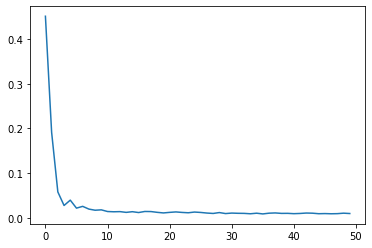

In [12]:
# Obtener la pérdida durante el entrenamiento
losses = history.history['loss']
print(losses)
plt.plot(range(len(losses)),losses)
plt.show()

In [13]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/tatatest.csv'
dataset_test = pd.read_csv(url)
real_stock_price = dataset_test.iloc[:, 1:2].values



In [14]:
real_stock_price_cierre = cierre[int(len(cierre) * 0.7):]
real_stock_price_cierre = np.reshape(real_stock_price_cierre, (real_stock_price_cierre.shape[0], 1))

In [15]:
# print(dataset_train['Open'])
# print(dataset_test['Open'])
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# # print(f"dataset_total: {dataset_total}, len: {len(dataset_total)}")
# # print(len(dataset_total) - len(dataset_test) - 60)
# #print(dataset_total)

# inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values#toma los primeros 76 elementos del dataset_total (que son los de entrenamiento)
# print(type(dataset_total))
# #le quita el conjunto de prueba - los ultimos 60 datos de entrenamiento
# # print(f"inputs: {inputs}, len: {len(inputs)}")
# print(f"inputs.shape {inputs.shape}")

# inputs = inputs.reshape(-1,1)
# print(f"inputs.shape {inputs.shape}")
# inputs = sc.transform(inputs)
# X_test = []
# for i in range(60, 76):
#     X_test.append(inputs[i-60:i, 0])
# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# predicted_stock_price = model.predict(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [16]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values

inputs_cierre = cierre[len(cierre) - len(real_stock_price_cierre) - time_steps:]#toma los ultimos 86 elementos, los ultimos 8 de entrenamiento y todos los de prueba  
#print(len(cierre) - len(real_stock_price_cierre) - time_steps)
inputs_cierre = np.array(inputs_cierre).reshape(-1,1)
#print(len(inputs_cierre))
#print(inputs_cierre.shape)
inputs_cierre = m_m_s.transform(inputs_cierre) # se normalizan los datos usandlo los parametros que se le dieron a m_m_s
X_test_cierre = []
for i in range(time_steps, len(inputs_cierre)):
    X_test_cierre.append(inputs_cierre[i-time_steps:i, 0]) # setoman en paquetes de 8 
X_test_cierre = np.array(X_test_cierre)
X_test_cierre = np.reshape(X_test_cierre, (X_test_cierre.shape[0], X_test_cierre.shape[1], 1))#(78, 8, 1)

predicted_stock_price_cierre = red.predict(X_test_cierre)
predicted_stock_price_cierre = m_m_s.inverse_transform(predicted_stock_price_cierre)

3/3 [==============================] - 1s 4ms/step


In [18]:
# plt.plot(real_stock_price, color = 'black', label = 'TATA Stock Price')
# plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
# plt.title('TATA Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('TATA Stock Price')
# plt.legend()
# plt.show()

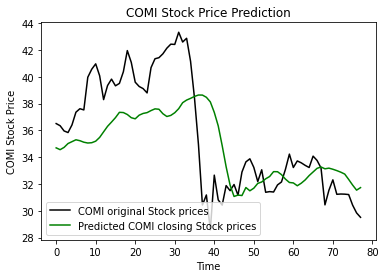

In [19]:
plt.plot(real_stock_price_cierre, color = 'black', label = 'COMI original Stock prices')
plt.plot(predicted_stock_price_cierre, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [34]:
print(y_train_c.size)

174


In [41]:
ts_cierre_s_pred = training_set_cierre_scaled

for epoch in range(20):  # Número de épocas
    ts_cierre_s_pred = training_set_cierre_scaled
    
    for i in range(time_steps, N):
        # Obtener las características y la etiqueta actual
        x_actual = ts_cierre_s_pred[i-time_steps:i,0].reshape(1,time_steps,1)
        y_actual = np.array([y_train_c[i-time_steps]])

        print(x_actual)
        print(f"y_actual: {y_actual}")
        # Predicción del modelo
        prediccion = red.predict(x_actual).reshape(1,1,1)

        # Entrenar el modelo con las nuevas características y la etiqueta real
        red.train_on_batch(x_actual, y_actual)

        # Agregar la predicción a las características para el siguiente paso
        print(x_actual)
        print(prediccion)
        x_actual = np.concatenate([x_actual, prediccion], axis=1)

[[[0.12010849]
  [0.01975978]
  [0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]]]
y_actual: [0.04610616]
1/1 [==============================] - 0s 38ms/step
[[[0.12010849]
  [0.01975978]
  [0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]]]
[[[0.20002942]]]
[[[0.01975978]
  [0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.04610616]]]
y_actual: [0.10422317]
1/1 [==============================] - 0s 38ms/step
[[[0.01975978]
  [0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.04610616]]]
[[[0.18543123]]]
[[[0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.04610616]
  [0.10422317]]]
y_actual: [0.1542038]
1/1 [==============================] - 0s 38ms/step
[[[0.        ]
  [0.01859744]
  [0.05656722]
  [0.02595893]
  [0.03448276]
  [0.04223169]
  [0.04610616]
  [0.10422317]]]
[[[0.17116

KeyboardInterrupt: 

In [17]:


for i in range(time_steps, N):
    X_train_c.append(training_set_cierre_scaled[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_train_c.append(training_set_cierre_scaled[i, 0])#se toma el elemento 8+1

# Ahora, el modelo ha sido entrenado de manera iterativa

# print(X_test_cierre.shape)
# print(X_test_cierre[0,:].shape)
f_X_test_cierre = np.reshape(X_test_cierre[0,:], (1, X_test_cierre[0,:].shape[0], 1))
# print(f_X_test_cierre)
f_predicted_sp_cierre = red.predict(f_X_test_cierre)
print(f"shape: {predicted_stock_price_cierre.shape}")
f_predicted_sp_cierre = m_m_s.inverse_transform(f_predicted_sp_cierre)
# print(f_X_test_cierre.reshape(8))

predicted_stock_price_cierre_pred = utls.genera_prediccion_predictiva(f_X_test_cierre.reshape(8),8,78,red)
print(f"shape: {predicted_stock_price_cierre_pred.shape}")
predicted_stock_price_cierre_pred = m_m_s.inverse_transform(predicted_stock_price_cierre_pred.reshape(86,1))
# input_shape_primera_capa = red.layers[0].input_shape
# print(input_shape_primera_capa[1:])

# arreglo_una_dimension = np.random.rand(8)  # Completa con tus valores reales

# # Utilizar input_shape_primera_capa en la función reshape
# arreglo_reshape = arreglo_una_dimension.reshape(1, *input_shape_primera_capa[1:])
# print(arreglo_reshape)


1/1 [==============================] - 0s 18ms/step
shape: (78, 1)
1/1 [==============================] - 0s 16ms/step
shape: (86,)


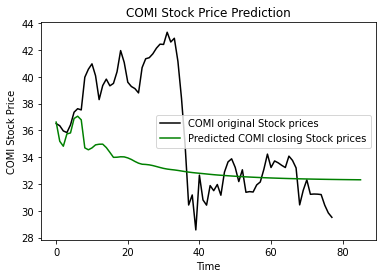

In [20]:

plt.plot(real_stock_price_cierre, color = 'black', label = 'COMI original Stock prices')
plt.plot(predicted_stock_price_cierre_pred, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [22]:
import torch
import torch.nn as nn
criterion = nn.MSELoss()
perdida = criterion(torch.tensor(real_stock_price_cierre),torch.tensor(predicted_stock_price_cierre))
print(perdida)
perdida = criterion(torch.tensor(real_stock_price_cierre),torch.tensor(predicted_stock_price_cierre_pred[:78]))
print(perdida)

tensor(10.5957, dtype=torch.float64)
tensor(19.1861, dtype=torch.float64)
